In [ ]:
import re
import cv2
import pytesseract
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from utils import hed_util
from utils import ocr_util
from utils import img_util

CWD_PATH = os.getcwd()
MODEL_NAME = 'model'
HED_NAME = 'HED'
TEST_IMAGE_PATH = os.path.join(CWD_PATH, 'test_images')
HED_PROTOTEXT_PATH = os.path.join(CWD_PATH,MODEL_NAME,HED_NAME,'deploy.prototxt')
HED_CAFFEE_MODEL_PATH = os.path.join(CWD_PATH,MODEL_NAME,HED_NAME,'hed_pretrained_bsds.caffemodel')
net = hed_util.load_dnn(HED_PROTOTEXT_PATH,HED_CAFFEE_MODEL_PATH)

In [ ]:
def preprocess(image, scale=1):
    #gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray,(image.shape[1]//scale,image.shape[0]//scale))
    #blur = cv2.blur(resized,(5,5))
    #thresh = cv2.threshold(resized, 100, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

    return resized

def dilate(image):
    kernel = np.ones((2,2),dtype=np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

    
#erosion
def erode(image):
    kernel = np.ones((1,1),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def reverse_color(img):
    return cv2.bitwise_not(img)

def opening(image):
    kernel = np.ones((1, 1), np.uint8) 
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


def getScale(image):
    height_scale = image.shape[0] // 540
    width_scale = image.shape[1] // 860
    return height_scale, width_scale

def sharpen(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)    


def imshow(src,title='title'):
    plt.title(title)
    plt.imshow(src)
    plt.show() 
    


In [ ]:
def drawbox(img):
    d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    n_boxes = len(d['text'])
    boxes = img
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)   
            
    plt.imshow(boxes)
    plt.show()

In [ ]:
img_file = os.path.join(TEST_IMAGE_PATH,'ocr/myhi00123.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
#cropped = img
cropped = img[300:,0:500]
#scale = 2
#cropped = cv2.resize(cropped,(image.shape[1]*scale,image.shape[0]*scale))
#cropped = cv2.medianBlur(cropped,3)
#cropped = opening(cropped)
cropped = cv2.bilateralFilter(cropped, 1, 55,55)
#cropped = cv2.GaussianBlur(cropped,(21,21),1)


#drawbox(cropped)
th1 = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
th2 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11, 6)
th3 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11, 6)

plt.imshow(cropped)
plt.show()
plt.imshow(th1)
plt.show()
plt.imshow(th2)
plt.show()
plt.imshow(th3)

In [ ]:
img_file = os.path.join(TEST_IMAGE_PATH,'ocr/myhi00005.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
#image = hed_util.crop_image(net, image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#gray = cv2.equalizeHist(gray)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
#cropped = img
card = img[300:,0:500]
#cropped = cv2.medianBlur(card,3)

cropped = cv2.bilateralFilter(card, 9, 60,60)
# Performing OTSU threshold 
#cropped = cv2.GaussianBlur(cropped,(13,13),3)
thresh1 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11, 9)
#ret, thresh1 = cv2.threshold(thresh1, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
#ret, t = cv2.threshold(cropped, 150, 255, cv2.THRESH_BINARY) 

# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17)) 
  
# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
imshow(dilation,'dilation')
# Finding contours 
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  
                                                 cv2.CHAIN_APPROX_SIMPLE) 
im2 = cropped.copy() 
im3 = card.copy()
plt.title('im3')
plt.imshow(im3)
plt.show() 
for cnt in contours: 
    x, y, w, h = cv2.boundingRect(cnt) 
    if(w>=100 and h>=20):  
        # Drawing a rectangle on copied image 
        cv2.drawContours(im2, [cnt], -1, (0,0,0), -1)
        #rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2) 

        # Cropping the text block for giving input to OCR 
        #cropped = im2[y:y + h, x:x + w] 
       
kernel = np.ones((25,25),np.uint8)
opening = cv2.morphologyEx(im2, cv2.MORPH_OPEN, kernel)
plt.title('opening')
plt.imshow(opening)
plt.show() 
#gray_op = cv2.cvtColor(opening, cv2.COLOR_BGR2GRAY)
contours_op, hierarchy_op = cv2.findContours(opening, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours_op, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt) 
rect = cv2.rectangle(card, (x, y), (x + w, y + h), (255, 0, 0), 2) 
cv2.drawContours(im3, [cnt], -1, (0, 0, 0), -1)
#cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
plt.title('join contour')
plt.imshow(card)
plt.show()  
text = card[y:y+h, x:x+w]
#thresh1 = cv2.GaussianBlur(text,(3,3),0)
#text = cv2.bilateralFilter(text, 5, 50,50)
plt.title('text')
plt.imshow(text)
plt.show()
sh = sharpen(text)
plt.title('sharpen')
plt.imshow(sh)
plt.show()
#sh = cv2.medianBlur(sh, 7)
sh = cv2.bilateralFilter(sh, 9, 60, 60)
threshold_value = cv2.threshold(sh, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[0]
print('threshold value ', threshold_value)
val, text_threshold = cv2.threshold(sh, threshold_value-10, 255, cv2.THRESH_BINARY)
print('value ', val)
plt.title('text_threshold')
plt.imshow(text_threshold)
plt.show()
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(sh,config = custom_config))

In [ ]:
#close to 0 = black, close to 255 = white gd binary = 80 for mykad
blur = cv2.bilateralFilter(card, 5, 50, 50)
#blur = cv2.medianBlur(card, 5)
plt.title('blur')
plt.imshow(blur)
plt.show()
threshold_value = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[0]
print('threshold value ', threshold_value)
val, text_threshold = cv2.threshold(card, threshold_value-26, 255, cv2.THRESH_BINARY)
print(' value ', val)
plt.title('text_threshold')
plt.imshow(text_threshold)
plt.show()
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(blur,config = custom_config))

In [ ]:
img_file = os.path.join(TEST_IMAGE_PATH,'mxw1mjqs564unz5mxghs2w94dqf7p6jrhe4uk09e59_front.jpeg')
#output_file = os.path.join(TEST_IMAGE_PATH,'normalize.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
imshow(image,'original')
image = cv2.resize(image,(640,480))
#cv2.imwrite(output_file, image)
image = img_util.dilate_crop_image(image)
imshow(image,'image')
#cv2.imwrite(output_file, image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#gray = cv2.equalizeHist(gray)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
imshow(img,'img')
scale = 2
card = img[300:,20:500]
(x1, y1, w1, h1) = img_util.dilate_inner_get_contour(card,iterations=1)
textarea = card[y1:y1+h1, x1:x1+w1]
imshow(textarea,'textarea')
textarea = img_util.sharpen(textarea)
enlarge = cv2.resize(textarea,(textarea.shape[1]*scale,textarea.shape[0]*scale))
enlarge = cv2.bilateralFilter(enlarge, 9, 60, 60)
imshow(enlarge,'enlarge')
ocr_text = pytesseract.image_to_string(enlarge, config = r'--oem 3 --psm 6')
print(ocr_text)


In [ ]:
import cv2
import numpy as np

# load color image
im = cv2.imread(img_file)
#im = img_util.dilate_crop_image(im)
im = cv2.resize(im,(860,540),cv2.INTER_AREA)
# smooth the image with alternative closing and opening
# with an enlarging kernel
morph = im.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# take morphological gradient
gradient_image = cv2.morphologyEx(morph, cv2.MORPH_GRADIENT, kernel)

# split the gradient image into channels
image_channels = np.split(np.asarray(gradient_image), 3, axis=2)

channel_height, channel_width, _ = image_channels[0].shape

# apply Otsu threshold to each channel
for i in range(0, 3):
    _, image_channels[i] = cv2.threshold(~image_channels[i], 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
    image_channels[i] = np.reshape(image_channels[i], newshape=(channel_height, channel_width, 1))

# merge the channels
image_channels = np.concatenate((image_channels[0], image_channels[1], image_channels[2]), axis=2)

# save the denoised image
#cv2.imwrite('output.jpg', image_channels)
imshow(image_channels,'output')
c1 = image_channels[360:,20:500]
imshow(c1,'c1')
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(c1,config = custom_config))

In [ ]:
img_file = os.path.join(TEST_IMAGE_PATH,'mxw14fw639anwz6gs93spea9cqsnghrw6t2l7qc7ze_front.jpeg')
output_file = os.path.join(TEST_IMAGE_PATH,'normalize.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = img_util.dilate_crop_image(image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
card = img[270:,20:500]
scale = image.shape[1] // 640 if image.shape[1] > 640 else 1
b_kernel = (25 * scale) + (1 if scale % 2 == 0 else 0)
thresh = cv2.adaptiveThreshold(card,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,b_kernel,9 * scale)
imshow(thresh,'thresh')
#cv2.imwrite(output_file, thresh)
sample = cv2.fastNlMeansDenoising(thresh, None, 51, 7, 31)
imshow(sample,'sample')
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(sample,config = custom_config))

try crop 1
try crop 2
failure


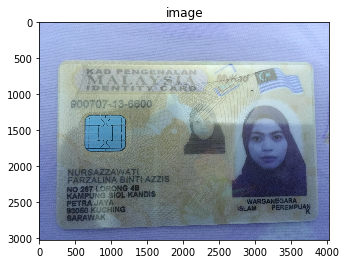

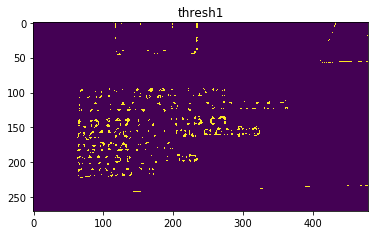

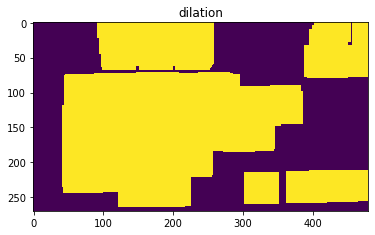

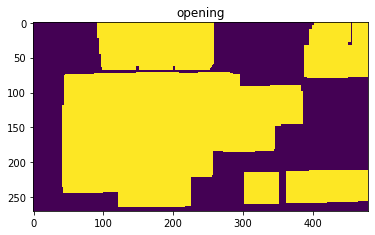

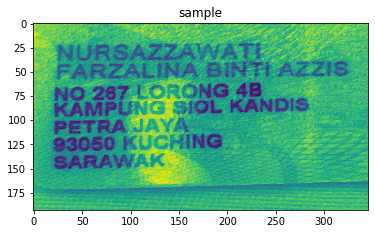

scale  1


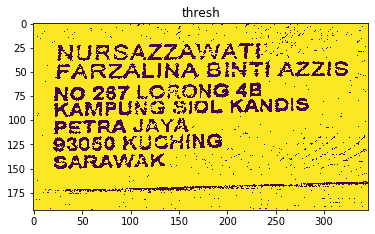

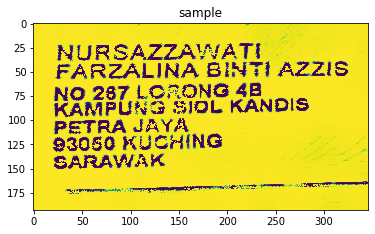

cropped:  NURSAZZAWATI
FARZALINA BINT! AZZIS
NO 287 LORONG 4B
KAMPUNS SIOL KANDIS
PETRA JAYA

93050 KUCHING

SARAWAK



In [33]:
img_file = os.path.join(TEST_IMAGE_PATH,'(9)00464.jpg')
output_file = os.path.join(TEST_IMAGE_PATH,'normalize.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
#image = hed_util.crop_image(net, image)
image = img_util.try_crop_image(image, threshold=0.3, iterations=3)
imshow(image,'image')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
card = img[270:,20:500]
blur = cv2.medianBlur(card,7)
#cleaning noise
thresh1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11, 9)  
imshow(thresh1,'thresh1')
# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (23, 23)) 

# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)   
imshow(dilation,'dilation')
# Finding dilation contours 
contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  
                                                cv2.CHAIN_APPROX_SIMPLE)     

im2 = blur.copy() 
im3 = card.copy()
cnt = max(contours, key=cv2.contourArea)
x1, y1, w1, h1 = cv2.boundingRect(cnt) 
kernel = np.ones((25,25),np.uint8)
opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)
imshow(opening,'opening')
#gray_op = cv2.cvtColor(opening, cv2.COLOR_BGR2GRAY)
contours_op, hierarchy_op = cv2.findContours(opening, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours_op, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt) 
rect = cv2.rectangle(im3, (x, y), (x + w, y + h), (255, 0, 0), 2) 
cv2.drawContours(im3, [cnt], -1, (0, 0, 0), -1)
#cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask

card = card[y1:y1+h1, x1:x1+w1]
imshow(card,'sample')
scale = image.shape[1] // 640 if image.shape[1] > 640 else 1
scale = 1
print('scale ', scale)
b_kernel = (25 * scale) - (1 if scale % 2 == 0 else 0)
thresh = cv2.adaptiveThreshold(card,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,b_kernel,13 * scale)
imshow(thresh,'thresh')
#cv2.imwrite(output_file, thresh)
sample = cv2.fastNlMeansDenoising(thresh, None, 51, 7, 31)
imshow(sample,'sample')
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(sample,config = custom_config))

In [ ]:
img_file = os.path.join(TEST_IMAGE_PATH,'mxw1mjqs564unz5mxghs2w94dqf7p6jrhe4uk09e59_front.jpeg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#blur image
blur = cv2.medianBlur(gray,7)
#cleaning noise
thresh1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv2.THRESH_BINARY_INV,11, 9)  

# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17)) 

# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 3)  
imshow(dilation,'dilation')